In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
import matplotlib as mpl
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

/usr/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'

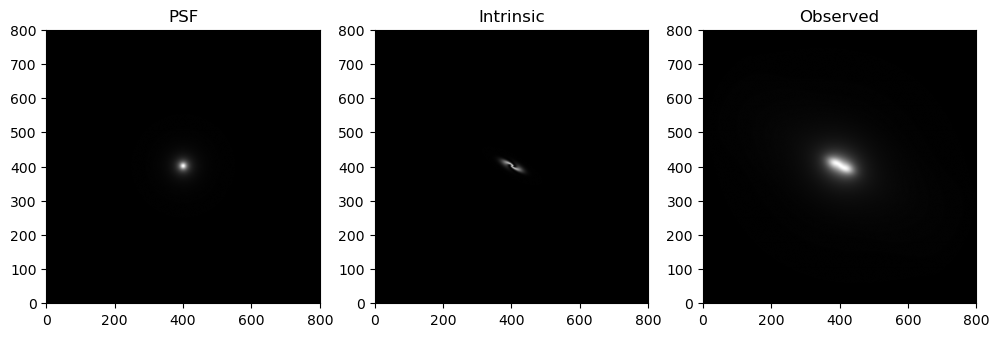

In [4]:
width = 800
height = 800

# Create PSF and Galaxy images
image_psf = moffat(width, height, 1, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [5]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, sigma_F = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.252185
The aperture flux using the observed image and rescaled weight function : 0.252173


In [306]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift

def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    negative_pixels = noise_image[noise_image<0]
    uncorrelated_variance = np.sum(negative_pixels**2)/len(negative_pixels)
    local_covariance = local_covariance / local_covariance[maxlag, maxlag] * uncorrelated_variance
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    # straightforward FFT autocorrelation
    F = fft2(img)
    ac = fftshift(ifft2(F * np.conj(F)).real)
    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window



def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

In [138]:
# np.random.seed(0)
n = 256
true_sigma = 0.01
noise = np.random.normal(0, true_sigma, (n, n))

C = covariance_fft2d(noise, maxlag=10)
print("FFT variance:", C[C.shape[0]//2, C.shape[1]//2], true_sigma**2)  # ≈ true_sigma²

s = np.ones((n, n))
V_pred = weighted_variance_lag(s, C, max_lag=10)
V_sim = np.var(noise * s)
print("Predicted σ:", np.sqrt(V_pred))
print("Simulated σ:", np.sqrt(V_sim))


FFT variance: 9.951667123558488e-05 0.0001
Predicted σ: 2.4746726044253875
Simulated σ: 0.009975974188128749


In [ ]:
weight_new = wiener_deconvolution(weight, image_psf)
weight_new /= np.sum(weight_new)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

0.004735606513393068 0.004980819941227175


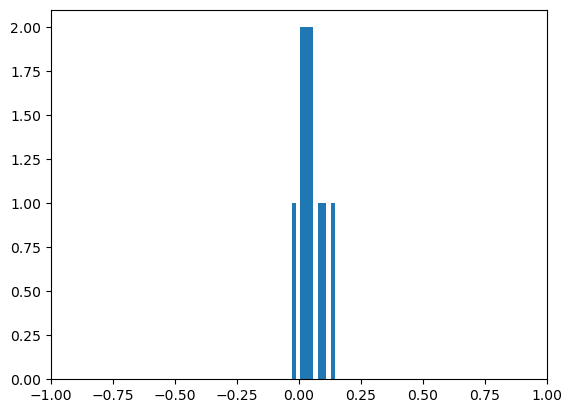

In [307]:
n_iterations = 10
flux = np.zeros(n_iterations)
sigma = np.zeros(n_iterations)
noise_psf = moffat(width, height, 10, 3)
maxlag = 10
for i in tqdm(range(n_iterations)):
    noise = np.random.normal(0, .1, (height, width))
    noise = fftconvolve(noise, noise_psf, mode="same") 
    noise *= 1
    noisy_image = image+noise
    flux[i], hi = calculate_gaap_flux(noisy_image, image_psf, weight, [(height / 2, width / 2)])
    sigma[i] = estimate_sigma(noisy_image[:300, :300], weight_new, maxlag)
print(np.std(flux), np.nanmean(sigma))
plt.hist((sigma- np.std(flux))/np.std(flux))
plt.xlim(-1, 1)
plt.show()


In [266]:
import numpy as np
from scipy.ndimage import uniform_filter

def find_noise_square(image, box_size=50, margin=3):
    """
    Automatically find a square region with low signal (noise-dominated).
    image: 2D array
    box_size: side of the square region (pixels)
    margin: exclude edges
    threshold: how many sigma above the median to consider as "source"
    returns: (y0, x0, y1, x1) slice indices of best noise square
    """
    img = np.asarray(image, float)
    h, w = img.shape

    # smooth absolute value to find low-variance zones
    local_mean = uniform_filter(img, size=box_size)
    local_var = uniform_filter(img**2, size=box_size) - local_mean**2
    local_std = np.sqrt(np.maximum(local_var, 0))

    # exclude borders
    local_std[:margin, :] = np.inf
    local_std[-margin:, :] = np.inf
    local_std[:, :margin] = np.inf
    local_std[:, -margin:] = np.inf

    # pick minimum std region (least structured)
    cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

    # ensure square fits inside image
    half = box_size // 2
    y0 = max(0, cy - half)
    x0 = max(0, cx - half)
    y1 = min(h, y0 + box_size)
    x1 = min(w, x0 + box_size)

    return y0, x0, y1, x1


In [275]:
location = '/net/vdesk/data2/deklerk/GAAP_data'
field = '53.0_-28.0'

In [273]:
import glob
from astropy.io import fits

In [300]:
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    real_image = hdul[0].data
# plt.imshow(np.log(real_image))
# plt.show()


In [308]:
y0, x0, y1, x1 = find_noise_square(real_image, 200)
print(y0, y1, x0, x1)

KeyboardInterrupt: 

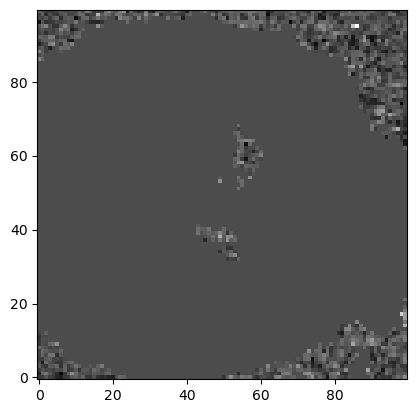

In [302]:
plt.imshow(real_image[y0:y1, x0:x1])
plt.show()

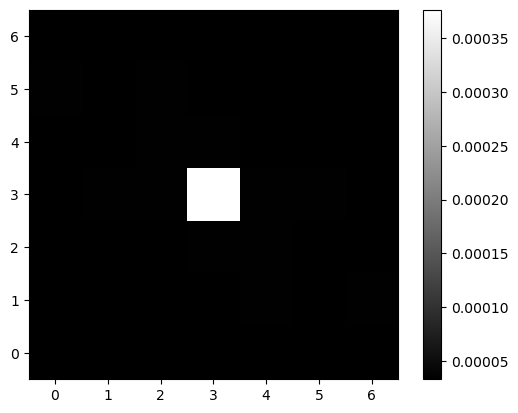

In [170]:
plt.imshow(local_cov)
plt.colorbar()
plt.show()

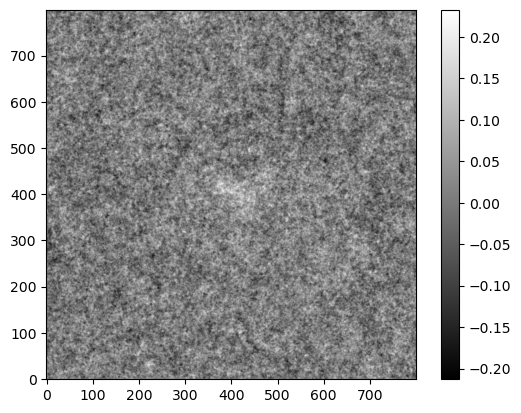

In [ ]:
plt.imshow(image+noise)
plt.colorbar()
plt.show()

In [10]:
noise_psf = moffat(width, height, 1, 1)
noise = np.random.normal(0, 0.05, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same")

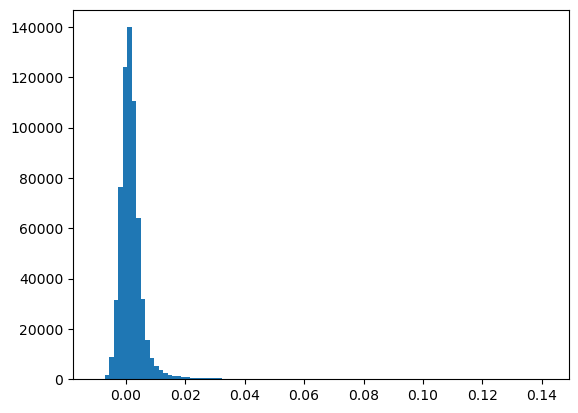

In [11]:
plt.hist((image+noise).flatten(), bins=100)
plt.show()

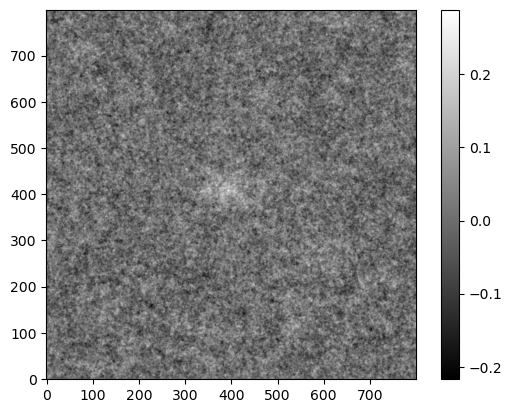

In [56]:
import cv2
Lx, Ly = 1, 1
I0 = (image+noise).copy()
# min = np.min(I0)
# I0[I0>-np.min(I0)] = 0
plt.imshow(I0)
plt.colorbar()
plt.show()
measured = covariance_fft2d(I0, Lx)
control = local_covariance(noise, Lx, Lx)

# plt.imshow(control)
# plt.colorbar()
# plt.show()


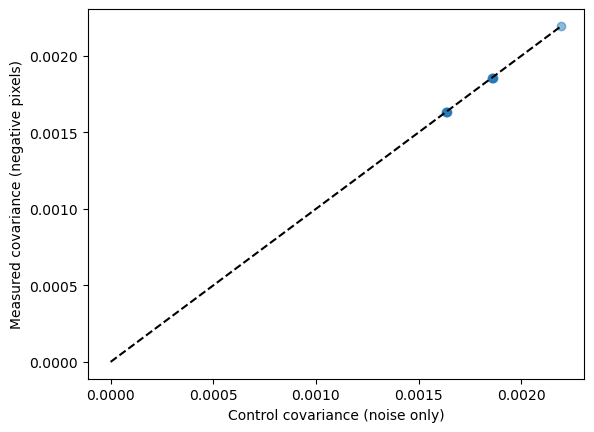

In [57]:
plt.scatter(control.flatten(), measured.flatten() - measured[Lx, Lx] + control[Lx, Lx], alpha=0.5)
plt.plot([0, np.max(control)], [0, np.max(control)], 'k--')
plt.ylabel('Measured covariance (negative pixels)')
plt.xlabel('Control covariance (noise only)')
plt.show()